# Team Q Final Project

The dataset we are going to be using to create the RS for this project has info about the games and the hours played of some steam users. The goal is to recommend new games, similar to the ones a gamer had played.

Link to steam dataset: https://github.com/caserec/Datasets-for-Recommender-Systems/tree/master/Processed%20Datasets/Steam

Below we list the various .dat files that we are going to use.

## Review the datasets

### Import libraries

In [9]:
import pandas as pd

### Read datasets
#### game_play.dat

In [10]:
games_play = pd.read_csv('steam/game_play.dat', delimiter='\t')
games_play

,User_ID,Game_ID,Hours
0,1,1,273.0
1,1,2,87.0
2,1,3,14.9
3,1,4,12.1
4,1,5,8.9
...,...,...,...
70484,12393,29,2.4
70485,12393,1828,2.2
70486,12393,2049,1.5
70487,12393,1073,1.5


This dataset contains the full play hours set: 70,490 interactions by 11,350 users on 3,600 games. Users and items are numbered consecutively from 1. The data is ordered by users ids.

#### game_purchase.dat

In [11]:
games_purchase = pd.read_csv('steam/game_purchase.dat', delimiter='\t')
games_purchase

,User_ID,Game_ID,Purchase
0,1,1,1.0
1,1,2,1.0
2,1,3,1.0
3,1,4,1.0
4,1,5,1.0
...,...,...,...
129506,12393,29,1.0
129507,12393,1828,1.0
129508,12393,2049,1.0
129509,12393,1073,1.0


This dataset contains the full purchase set: 129,512 interactions by 12,393 users on 5,155 games. Users and items are numbered consecutively from 1. The data is ordered by users ids.
#### item_info.dat

In [12]:
items_info = pd.read_csv('steam/item_info.dat', delimiter='\t')
items_info

,Game_ID,Game Name
0,1,The Elder Scrolls V Skyrim
1,2,Fallout 4
2,3,Spore
3,4,Fallout New Vegas
4,5,Left 4 Dead 2
...,...,...
5150,5151,Warriors & Castles
5151,5152,Romance of the Three Kingdoms Maker
5152,5153,Space Colony
5153,5154,Life is Hard


This dataset contains information about the items (games)

The item ids are the ones used in the game_purchase.dat and game_play.dat files.
#### user_info.dat

In [13]:
users_info = pd.read_csv('steam/user_info.dat', delimiter='\t')
users_info

,New_ID,Real_ID
0,1,151603712
1,2,187131847
2,3,59945701
3,4,53875128
4,5,234941318
...,...,...
12388,12389,125424716
12389,12390,99096740
12390,12391,176449171
12391,12392,221315846


This dataset contains IDs information about the users.

The user ids are the ones used in the game_purchase.dat and game_play.dat files.

## Dataset preprocessing

In [14]:
#Read the dataset and put it in a dataframe
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#Load data
play_data_df = pd.read_csv('steam/game_play.dat', delimiter='\t')

item_info_df = pd.read_csv('steam/item_info.dat', delimiter='\t')

In [15]:
#From the data remove any duplicate groups of User_ID - Game_ID and only keep the first
play_data_df.drop_duplicates(subset=['User_ID','Game_ID'],keep='first',inplace=True)
play_data_df

,User_ID,Game_ID,Hours
0,1,1,273.0
1,1,2,87.0
2,1,3,14.9
3,1,4,12.1
4,1,5,8.9
...,...,...,...
70484,12393,29,2.4
70485,12393,1828,2.2
70486,12393,2049,1.5
70487,12393,1073,1.5


In [16]:
# Create a 2d array consisting of max_user_id rows and max_game_id columns it is initialized with zeroes
# and then  for each row in the dataframe we place the hours played in the correct cell in the array

max_user_id = int(play_data_df['User_ID'].max())
max_game_id = int(play_data_df['Game_ID'].max())

num_users_play = max_user_id
num_items_play = max_game_id

play_matrix = np.zeros((int(num_users_play), int(num_items_play)))
for _, row in play_data_df.iterrows():
    user_id, game_id, hours_played = row['User_ID'], row['Game_ID'], row['Hours']
    play_matrix[int(user_id) - 1, int(game_id) - 1] = hours_played
num_zero_entries = np.count_nonzero(play_matrix == 0)
# Calculate the total number of entries
total_entries = play_matrix.size

# Calculate the sparsity
sparsity = (num_zero_entries / total_entries) * 100

print("Number of zero entries:", num_zero_entries)
print("Total number of entries:", total_entries)
print("Sparsity:", sparsity, "%")

Number of zero entries: 63815438
Total number of entries: 63885915
Sparsity: 99.88968303889833 %


In [17]:
#Split the data in a training and test set to find the error later.
train_data, test_data = train_test_split(play_matrix, test_size=0.2, random_state=42)

#combined_data = np.concatenate((train_data,test_data),axis =0)

In [18]:
def matchNamesToID(game_ids):
    game_names = []
    for game_id_play, _ in game_ids:
        game_name = item_info_df.loc[item_info_df['Game_ID'] == game_id_play, 'Game Name'].values[0]
        game_names.append((game_id_play, game_name))
    return game_names

## SVD method

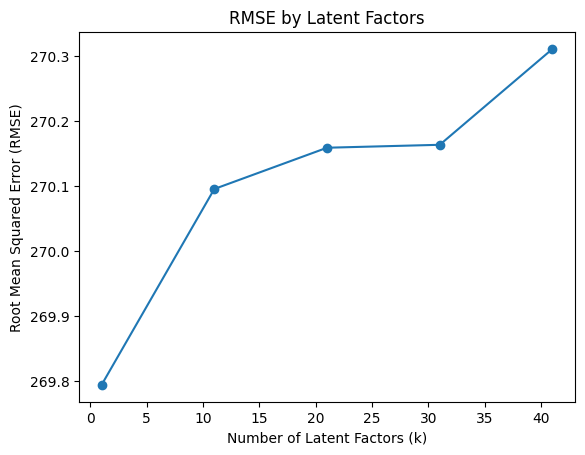

In [19]:
import matplotlib.pyplot as plt

k_values = range(1,51,10)
rmse_values = []

for k in k_values:
    U, Sigma, Vt = svds(train_data, k=k)
    Sigma_diag_play = np.diag(Sigma)

    predicted_matrix_play = np.dot(np.dot(U, Sigma_diag_play), Vt)
    actual_playtime = test_data[test_data.nonzero()]

    predicted_playtime = predicted_matrix_play[test_data.nonzero()]
    # Calculate the Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(actual_playtime, predicted_playtime))
    rmse_values.append(rmse)

plt.plot(k_values, rmse_values, marker='o')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE by Latent Factors')
plt.show()

Since the error does not get reduced by increasing the latent factors we can choose a small value for them.

In [20]:
U_play, Sigma_play, Vt_play = svds(train_data, k=1)

#Make sigma into a diagonal
Sigma_diag_play = np.diag(Sigma_play)

# Reconstruct the predicted playtime matrix
predicted_matrix_play = np.dot(np.dot(U_play, Sigma_diag_play), Vt_play)
# Flatten the actual and predicted playtime matrices for evaluation
actual_playtime = test_data[test_data.nonzero()]

predicted_playtime = predicted_matrix_play[test_data.nonzero()]
print(actual_playtime.shape)
print(predicted_playtime.shape)

(13966,)
(13966,)


In [21]:
def getPredictionSVD(userID):
  user_id_play = userID
  user_play_ratings = predicted_matrix_play[user_id_play - 1, :]
  unplayed_items_play = np.where(play_matrix[user_id_play - 1, :] == 0)[0]

  # Get predicted playtime for unplayed items
  predicted_playtime = [(item + 1, user_play_ratings[item]) for item in unplayed_items_play]

  # Sort the recommendations by predicted playtime
  sorted_recommendations_play = sorted(predicted_playtime, key=lambda x: x[1], reverse=True)

  # Display the top recommendations with game names
  top_recommendations_play = sorted_recommendations_play[:10]  # Top 10 recommendations
  print("\nTop Recommendations for User", user_id_play)
  for game_id_play, _ in top_recommendations_play:
      game_name = item_info_df.loc[item_info_df['Game_ID'] == game_id_play, 'Game Name'].values[0]
      print(f"Game Name: {game_name}")

In [22]:
getPredictionSVD(1)


Top Recommendations for User 1
Game Name: Counter-Strike Global Offensive
Game Name: Counter-Strike
Game Name: Counter-Strike Source
Game Name: PAYDAY 2
Game Name: Warframe
Game Name: Grand Theft Auto V
Game Name: Rust
Game Name: Sid Meier's Civilization V
Game Name: Dark Messiah of Might & Magic Multi-Player
Game Name: DayZ


Game_ID
22     981684.6
54     322771.6
10     173673.3
612    134261.1
43      99821.3
545     96075.5
1       70889.3
25      49725.3
271     42009.9
5       33596.7
Name: Hours, dtype: float64


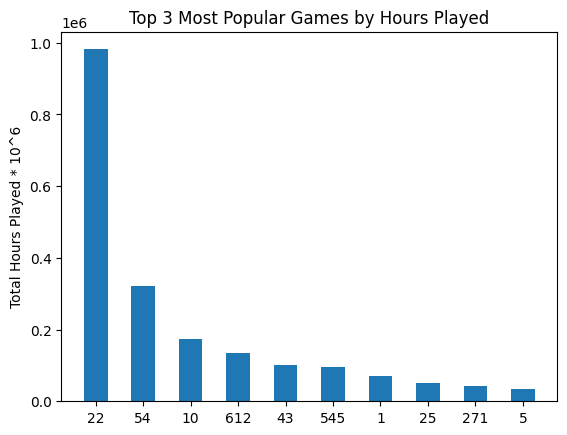

In [23]:
import matplotlib.pyplot as plt

# Assuming 'game_play.dat' contains the game play data
game_play_df = pd.read_csv('steam/game_play.dat', delimiter='\t')

# Assuming 'item_info.csv' contains the item information with columns 'Game_ID' and 'Game_Name'
item_info_df = pd.read_csv('steam/item_info.dat', delimiter ='\t')

total_hours_per_game = game_play_df.groupby('Game_ID')['Hours'].sum()

# Select the 3 games with the highest total hours played
top_games = total_hours_per_game.nlargest(10)
print(top_games)

# Create a list of unique colors for each bar
bar_colors = ['tab:blue' for _ in range(len(top_games))]

# Set the minimum width for each bar
min_width = 0.5

# Set 'Game_ID' as the index for direct indexing
top_games.index = top_games.index.map(str)  # Ensure 'Game_ID' is treated as a string
# Plot the 3 most popular games as horizontal bar plot with minimum width
fig, ax = plt.subplots()
bars = ax.bar(top_games.index, top_games.values, color=bar_colors, width=min_width)

# Add game names from item_info dataset as annotations
ax.set_ylabel('Total Hours Played * 10^6')
ax.set_title('Top 3 Most Popular Games by Hours Played')

plt.show()

## Neural Nets

In [ ]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from keras.callbacks import LearningRateScheduler

X = np.column_stack(np.where(play_matrix > 0))
y = play_matrix[play_matrix > 0]
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=10)



# Define the model
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(2,), name ='dense_1'))
model.add(Dense(3, activation='relu', input_shape=(2,), name ='dense_2'))
model.add(Dense(1, activation='linear', name='output_layer'))

checkpoint_callback = ModelCheckpoint('recommenderNN_epoch_{epoch:02d}.keras', save_freq='epoch')

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam())
# Fit the model
model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/20
1322/1322 [==============================] - 8s 5ms/step - loss: 62860.1523 - val_loss: 56328.1445
Epoch 2/20
1322/1322 [==============================] - 5s 4ms/step - loss: 50521.6328 - val_loss: 56259.1133
Epoch 3/20
1322/1322 [==============================] - 7s 5ms/step - loss: 50555.1172 - val_loss: 56652.6680
Epoch 4/20
1322/1322 [==============================] - 5s 4ms/step - loss: 50670.4961 - val_loss: 56215.4609
Epoch 5/20
1322/1322 [==============================] - 5s 4ms/step - loss: 50531.0156 - val_loss: 56923.5312
Epoch 6/20
1322/1322 [==============================] - 5s 4ms/step - loss: 50469.7695 - val_loss: 56249.1484
Epoch 7/20
1322/1322 [==============================] - 5s 4ms/step - loss: 50365.7930 - val_loss: 56623.2227
Epoch 8/20
1322/1322 [==============================] - 6s 4ms/step - loss: 50339.9922 - val_loss: 56184.2461
Epoch 9/20
1322/1322 [==============================] - 5s 4ms/step - loss: 50310.3789 - val_loss: 56112.9570
Epoch 10/2

In [24]:
#Load the model
from keras.models import load_model

# Load the saved model
loaded_model = load_model('recommenderNN.keras')

In [25]:
X = np.column_stack(np.where(play_matrix > 0))  # Input features (user and game pairs)
y = play_matrix[play_matrix > 0]
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=10)

y_pred = loaded_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', rmse)

221/221 [==============================] - 1s 3ms/step
Root Mean Squared Error: 246.3773539630659


In [ ]:
from keras.models import save_model

# Assuming your model is named 'model'
model.save('recommenderNN.keras')  # Save the model to a file named 'my_model.h5'

In [ ]:
from google.colab import files

files.download('recommenderNN.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
def predict_playtime_for_user(user_id, model, game_ids):
    # Create input features for the specified user and game IDs
    user_game_pairs = np.column_stack((np.full(len(game_ids), user_id), game_ids))
    # Use the trained model to predict playtime
    playtime_predictions = model.predict(user_game_pairs)

    # Flatten the predictions
    playtime_predictions = playtime_predictions.flatten()

    # Create a DataFrame with the game IDs and corresponding predictions
    predictions_df = pd.DataFrame({'GameID': game_ids, 'PredictedPlaytime': playtime_predictions})
    game_purchase_df = pd.read_csv('steam/game_purchase.dat', delimiter='\t')
    # Filter out games already purchased by the user
    purchased_games = game_purchase_df[game_purchase_df['User_ID'] == user_id]['Game_ID'].values
    predictions_df = predictions_df[~predictions_df['GameID'].isin(purchased_games)]

    # Sort the DataFrame by predicted playtime in descending order
    predictions_df = predictions_df.sort_values(by='PredictedPlaytime', ascending=False)

    return predictions_df.head(10)  # Return the top 10 predictions

In [27]:
user_id_to_predict = 9000 # Replace with the user ID you want to predict for
game_ids_to_predict = range(1,num_items_play+1)

predictions = predict_playtime_for_user(user_id_to_predict, loaded_model, game_ids_to_predict)
print("\nTop Recommendations for User", user_id_to_predict)
for game_id_play in predictions['GameID'].values:
    game_name = item_info_df.loc[item_info_df['Game_ID'] == game_id_play, 'Game Name'].values[0]
    print(f"Game Name: {game_name}")

162/162 [==============================] - 0s 1ms/step

Top Recommendations for User 9000
Game Name: The Elder Scrolls V Skyrim
Game Name: SpellForce 2 - Demons of the Past
Game Name: Pinball FX2 - Paranormal Table
Game Name: Pinball FX2 - Epic Quest Table
Game Name: Pinball FX2 - Earth Defense Table
Game Name: Pinball FX2 - Core pack
Game Name: MotoGP13 Moto2 and Moto3
Game Name: MotoGP13 2012 Top Riders
Game Name: DarkBase 01
Game Name: Agricultural Simulator 2011 Extended Edition


In [28]:
getPredictionSVD(user_id_to_predict)


Top Recommendations for User 9000
Game Name: Dota 2
Game Name: Counter-Strike Global Offensive
Game Name: Counter-Strike
Game Name: Team Fortress 2
Game Name: Counter-Strike Source
Game Name: The Elder Scrolls V Skyrim
Game Name: Path of Exile
Game Name: PAYDAY 2
Game Name: Left 4 Dead 2
Game Name: Garry's Mod
